<h1 align="center">Create Stance Labels for the Army's YouTube Comments</h1>
We are now going to use snorkel (and its functionality with things like labeling functions) combined with the previous LLM labels in order to label the comments to the Army's YouTube videos for their stance toward the U.S. Army.

In [29]:
# Import packages

import pandas as pd, numpy as np, os, hashlib
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

from snorkel.labeling import labeling_function, PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import LabelModel
from snorkel.labeling.model.baselines import MajorityLabelVoter

from transformers import pipeline

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define possible labels for the weak labelers

SUPPORT = 1
AGAINST = 2
NEUTRAL = 0
ABSTAIN = -1

# Read in and inspect the dataset to be labeled

We will read in the validation dataset, which we labeled earlier, for this exercise. The full data set is available [here](https://zenodo.org/records/10493803)

In [32]:
DATA_PATH = "@usarmy_comments_validation_set_labeled.csv"

df = pd.read_csv(DATA_PATH, index_col=0)

In [33]:
df.shape

(1000, 22)

In [34]:
df.head()

,id,comment,author,author_channel,like_count,published_at,coversation_id,video_id,name,description,...,stance_toward_the_video_1,stance_toward_army_2,stance_toward_the_video_2,stance_toward_army_3,stance_toward_the_video_3,stance_toward_army_4,stance_toward_the_video_4,stance_toward_army,stance_toward_the_video,llm_labels
Column1,,,,,,,,,,,,,,,,,,,,,
22003,UgwoQjnFnu8oh8pn8gV4AaABAg,This looks fun,FinnWarrior,UCftLalD5oiEhoQ8fMjWVHYA,56,6/2/2023 9:08,UgwoQjnFnu8oh8pn8gV4AaABAg,YT6nY1MbAqY,How was your #Army week?,"Training is complete! Enjoy the rest, #Soldier...",...,supports,NaN,NaN,NaN,NaN,neutral,supports,neutral,supports,for
129279,UgwIIyx_S9bFcAlTaXJ4AaABAg,Be a good goy and enlist today!,Crawlz,UCMRIsquChpFBwZ9e2CzyjIQ,9,4/3/2023 21:53,UgwIIyx_S9bFcAlTaXJ4AaABAg,Lwx-2R9swDg,Be All You Can Be - U.S. Army's new brand trai...,Soldiers know what it means to Be All You Can ...,...,against,NaN,NaN,NaN,NaN,against,against,against,against,for
35799,Ugyp3sxiuELgscnDhEt4AaABAg,I love U.S. army!,Mashal Azhar,UCEr0tOwggp9KeRNUb-MSF0w,2,9/7/2023 9:11,Ugyp3sxiuELgscnDhEt4AaABAg,oSp0kWcHJcc,Army 101: Ranks - Enlisted Ranks | U.S. Army,"Enlisted ranks in the #USArmy. What are they, ...",...,supports,NaN,NaN,NaN,NaN,supports,supports,supports,supports,for
109853,UgzTqqqHg0Sqp4UNoyN4AaABAg,Outstanding Cadets! Keep busy! Summer of 78!,Ralph Brogdon,UCPRlIt0Fxj09Tsu-ikOX0ZQ,6,7/6/2023 9:52,UgzTqqqHg0Sqp4UNoyN4AaABAg,koutUr0IWHk,So what's ROTC Summer training like?,ROTC cadets undergo #Armytraining every summer...,...,supports,NaN,NaN,NaN,NaN,supports,supports,supports,supports,for
130430,UgwtIVJIVI_hL3kXRex4AaABAg,"I hate people that say ""die for our country"" l...",nerdzilla1954,UCaJ7eXZ9mRczw2xLqX8CkCA,1,3/28/2023 1:55,UgwtIVJIVI_hL3kXRex4AaABAg,Lwx-2R9swDg,Be All You Can Be - U.S. Army's new brand trai...,Soldiers know what it means to Be All You Can ...,...,neutral,NaN,NaN,NaN,NaN,supports,neutral,supports,neutral,against


In [35]:
df.columns

Index(['id', 'comment', 'author', 'author_channel', 'like_count',
       'published_at', 'coversation_id', 'video_id', 'name', 'description',
       'timestamp', 'stance_toward_army_1', 'stance_toward_the_video_1',
       'stance_toward_army_2', 'stance_toward_the_video_2',
       'stance_toward_army_3', 'stance_toward_the_video_3',
       'stance_toward_army_4', 'stance_toward_the_video_4',
       'stance_toward_army', 'stance_toward_the_video', 'llm_labels'],
      dtype='object')

# Create the Weak Labels

At this point, we now want to create labeling functions around all of our possible weak labels. These include:

- LLM labeling
- Other ML model labels
- Hueristic Labels

## Add in LLM Created Labels

In [38]:
@labeling_function()
def check_llm(row):
    if row['llm_labels'] == 'for':
        return SUPPORT
    elif row['llm_labels'] == 'against':
        return AGAINST
    else:
        return NEUTRAL

## Add in Additonal ML-derived Weak Labels

We can often use other Foundation ML models to label things related to the target label we want. For example, we could reason that stance is probably correlated with sentiment, as negative emotionality is usually used to express an opinion against something. Similarly, the presence of hate speech might also be indicative of a negative opinion towards something

In [41]:
sentiment_analysis_pipeline = pipeline( model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
                                        return_all_scores=True, device =-1)

def get_sentiment(row):
    """
    Classifies the sentiment of a text using a sentiment analysis pipeline.

    Parameters:
    - row (pd.Series): A row from a pandas DataFrame containing a 'comment' column.

    Returns:
    - str: 'positive', 'negative', or 'neutral' based on the sentiment analysis results.
    """
    # Get the text from the row
    text = row['comment']
    
    try:
        # Perform sentiment analysis
        results = sentiment_analysis_pipeline(text)
        positive_score = results[0][0]['score'] if results[0][0]['label'] == 'positive' else 0
        neutral_score = results[0][1]['score'] if results[0][1]['label'] == 'neutral' else 0
        negative_score = results[0][2]['score'] if results[0][2]['label'] == 'negative' else 0
    except:
        positive_score, neutral_score, negative_score = 0, 0, 0

    return positive_score, negative_score, neutral_score

z:\Users\Iain\Documents\Data Science Competitions\rapid-ml-prototyping\Data Labeling\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [42]:
df[['positive_score', 'negative_score', 'neutral_score']] = df.progress_apply(
    lambda row: pd.Series(get_sentiment(row)), axis=1
)

100%|██████████| 1000/1000 [00:19<00:00, 52.12it/s]


In [43]:
@labeling_function()
def check_sentiment(row):
    positive_score = row['positive_score']
    neutral_score = row['neutral_score']
    negative_score = row['negative_score']

    if positive_score > 0.75:
        return SUPPORT
    elif negative_score > 0.6:
        return AGAINST
    elif neutral_score > 0.6:
        return NEUTRAL
    else:
        return ABSTAIN


## Add in Hueristic Weak Labels

We can also add in hueristically-defined labels for the targeted label. A common example is some key words are often associated with a particular label. So, based on some manual inspection, we'll use some key words that seem to correlate will with being for or against our target (i.e., the U.S. Army).

Once again, note that we don't have to have full coverage with these words, as with weak supervision the weak labels can have an `abstain` designation as well.

In [44]:
@labeling_function()
def check_for_negative_keywords(row):
    """
    Check if the 'comment' column contains negative keywords.
    
    Parameters:
    - row: pandas.Series, a row from a DataFrame
    
    Returns:
    - str: 'AGAINST' if negative keywords are found, 'ABSTAIN' otherwise
    """
    negative_keywords = {' suicide', ' PTSD', ' murder', ' criminal', ' woke', ' tranny', ' queer', ' equal rights', ' transgender', ' lgbt',
                         ' rape', ' rapist', ' shame', ' bullshit', ' bs', ' disgusted', ' toxic',
                         ' satan', ' corrupt', ' wtf', ' waste', ' lie', ' evil', ' imperialist',
                         ' go air force', ' go navy', ' go marine', ' jew',
                         ' white suprem', ' white men', ' white priv', ' whites', ' anti white',
                         ' zog', ' goy', ' moms', ' sodom', ' misleading', ' empire', ' bloodshed', 
                         ' barbarian', ' culture shock', ' progressive', ' pronouns', ' rotten'
                        }
    
    # Convert the comment text to lowercase for case-insensitive matching
    comment_text = str(row['comment']).lower()
    
    # Check for the presence of negative keywords
    if any(keyword in comment_text for keyword in negative_keywords):
        return AGAINST
    else:
        return ABSTAIN

In [45]:
@labeling_function()
def check_for_political_keywords(row):
    """
    Check if the 'comment' column contains keywords related to political or social issues.
    
    Parameters:
    - row: pandas.Series, a row from a DataFrame
    
    Returns:
    - str: 'AGAINST' if keywords related to political or social issues are found, 'ABSTAIN' otherwise
    """
    political_keywords = {'afghanistan', 'iraq', 'military budget', 'veteran healthcare', 'drone strike', ' politician',
                          'military spending', 'militarization of police', 'human rights violation', ' tax money', ' tax dollar', 
                          'genocide', 'war crime', 'intervention', 'propaganda'}
    
    comment_text = str(row['comment']).lower()
    
    if any(keyword in comment_text for keyword in political_keywords):
        return AGAINST
    else:
        return ABSTAIN

In [46]:
@labeling_function()
def check_for_positive_keywords(row):
    """
    Check if the 'comment' column contains positive keywords.
    
    Parameters:
    - row: pandas.Series, a row from a DataFrame
    
    Returns:
    - str: 'AGAINST' if negative keywords are found, 'ABSTAIN' otherwise
    """
    positive_keywords = {'hooah', 'airborne', 'glad', 'thank you', 'respect', 'awesome', 'god bless',
                        'hero', 'proud', 'best', 'go army', 'outstanding', 'excellent', 'well done', 
                         'rangers', 'motivating', 'love', 'dedicated', 'patriot', 'brave', "👍", "❤️", "💪", "👏"
                        }
    
    # Convert the comment text to lowercase for case-insensitive matching
    comment_text = str(row['comment']).lower()
    
    # Check for the presence of positive keywords
    if any(keyword in comment_text for keyword in positive_keywords):
        return SUPPORT
    else:
        return ABSTAIN

We can also add heuristic labeling functions around other aspects than the text itself, such as the meta-data. So, perhaps we have an intuition that liked comments are more likely to be valenced.

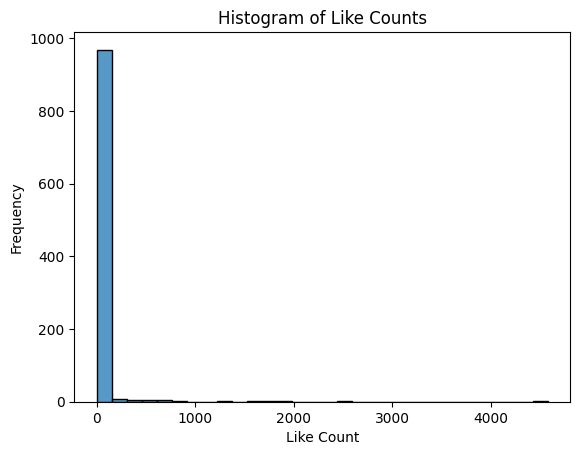

In [47]:
# Plot a histogram of the 'like_count' column
sns.histplot(data=df, x='like_count', bins=30, kde=False)

# Add labels and a title
plt.xlabel('Like Count')
plt.ylabel('Frequency')
plt.title('Histogram of Like Counts')

# Show the plot
plt.show()

In [48]:
@labeling_function()
def check_comment_like_count(row):
    like_count = row['like_count']
    
    if like_count <=1:
        return NEUTRAL
    else:
        return ABSTAIN

# Check labeling coverage and statistics

In [49]:
lfs = [
       check_llm,
       check_sentiment,
       check_for_negative_keywords,
       check_for_political_keywords,
       check_for_positive_keywords,
       check_comment_like_count
]

In [50]:
applier = PandasLFApplier(lfs=lfs)
L_army = applier.apply(df=df)

100%|██████████| 1000/1000 [00:00<00:00, 21069.39it/s]


In [51]:
LFAnalysis(L=L_army, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_llm,0,"[0, 1, 2]",1.000,0.731,0.397
check_sentiment,1,"[0, 1, 2]",0.396,0.396,0.206
check_for_negative_keywords,2,[2],0.087,0.087,0.035
check_for_political_keywords,3,[2],0.027,0.027,0.016
check_for_positive_keywords,4,[1],0.233,0.233,0.123
check_comment_like_count,5,[0],0.393,0.393,0.319


# Create Gold Standard Labels for Stance toward the U.S. Army

In [52]:
label_model = LabelModel(cardinality=3, verbose=True)

In [53]:
label_model.fit(L_train=L_army, n_epochs=1000, log_freq=100)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/1000 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.920]
INFO:root:[100 epochs]: TRAIN:[loss=0.029]
 27%|██▋       | 273/1000 [00:00<00:00, 1358.77epoch/s]INFO:root:[300 epochs]: TRAIN:[loss=0.001]
INFO:root:[400 epochs]: TRAIN:[loss=0.001]
 69%|██████▊   | 686/1000 [00:00<00:00, 1368.45epoch/s]INFO:root:[700 epochs]: TRAIN:[loss=0.001]
INFO:root:[800 epochs]: TRAIN:[loss=0.001]
100%|██████████| 1000/1000 [00:00<00:00, 1319.81epoch/s]
INFO:root:Finished Training


In [54]:
label_model.predict_proba(L_army)

array([[3.10212535e-02, 9.68957080e-01, 2.16668974e-05],
       [9.56340369e-04, 9.98862038e-01, 1.81621795e-04],
       [8.84549477e-04, 9.99112729e-01, 2.72188511e-06],
       ...,
       [3.10212535e-02, 9.68957080e-01, 2.16668974e-05],
       [7.40467209e-01, 8.40232192e-02, 1.75509571e-01],
       [3.29868036e-01, 5.65813407e-02, 6.13550623e-01]])

In [55]:
df['machine_stance_toward_army'] = label_model.predict(L_army, tie_break_policy='abstain')
df['machine_stance_toward_army'] = df['machine_stance_toward_army'].replace({1:'supports', 2:'against', 0:'neutral', -1:'abstain'})

In [56]:
df['machine_stance_toward_army'].value_counts()

machine_stance_toward_army
against     434
supports    377
neutral     189
Name: count, dtype: int64

In [57]:
[print(f"weak labeler: {i[0].name}, weight: {i[1]}") for i in zip(lfs, np.around(label_model.get_weights(), 2))]

weak labeler: check_llm, weight: 0.75
weak labeler: check_sentiment, weight: 0.9
weak labeler: check_for_negative_keywords, weight: 1.0
weak labeler: check_for_political_keywords, weight: 0.82
weak labeler: check_for_positive_keywords, weight: 0.89
weak labeler: check_comment_like_count, weight: 0.43


[None, None, None, None, None, None]

Finally, lets comapre our labels to the actual labels on this validation set

In [58]:
df.columns

Index(['id', 'comment', 'author', 'author_channel', 'like_count',
       'published_at', 'coversation_id', 'video_id', 'name', 'description',
       'timestamp', 'stance_toward_army_1', 'stance_toward_the_video_1',
       'stance_toward_army_2', 'stance_toward_the_video_2',
       'stance_toward_army_3', 'stance_toward_the_video_3',
       'stance_toward_army_4', 'stance_toward_the_video_4',
       'stance_toward_army', 'stance_toward_the_video', 'llm_labels',
       'positive_score', 'negative_score', 'neutral_score',
       'machine_stance_toward_army'],
      dtype='object')

In [59]:
print(f"Accuracy Score for stance toward Army: {accuracy_score(df['stance_toward_army'], df['machine_stance_toward_army'])}")
print(f"Micro F1-Score for stance toward Army: {f1_score(df['stance_toward_army'], df['machine_stance_toward_army'], average='micro')}")

Accuracy Score for stance toward Army: 0.617
Micro F1-Score for stance toward Army: 0.617


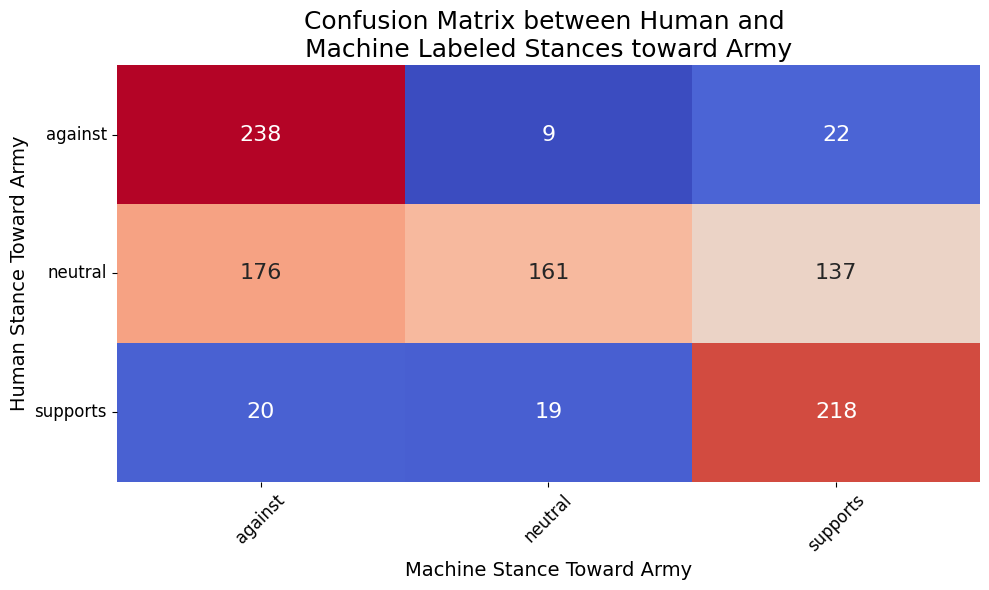

In [60]:
# Create the cross-tabulation
cross_tab_df = pd.crosstab(df['stance_toward_army'], df['machine_stance_toward_army'])

# Plot heatmap with updated font sizes and replacements
plt.figure(figsize=(10, 6))  # Adjust figure size
sns.heatmap(cross_tab_df, annot=True, fmt='d', cmap='coolwarm', cbar=False, annot_kws={'size': 16})  # Set annotation size
plt.title('Confusion Matrix between Human and \nMachine Labeled Stances toward Army', fontsize=18)  # Set title font size
plt.xlabel('Machine Stance Toward Army', fontsize=14)  # Set x-axis label font size
plt.ylabel('Human Stance Toward Army', fontsize=14)  # Set y-axis label font size
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis tick labels and set font size
plt.yticks(rotation=0, fontsize=12)  # Set y-axis tick labels and font size
plt.tight_layout()  # Ensure the layout fits within the figure
plt.show()